<a href="https://colab.research.google.com/github/raheelam98/generative_ai/blob/main/RAG/rag_with_google_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Class-06: AI-201- Advance RAG with Chroma DB and Milvus DB, Image & Audio RAG](https://www.youtube.com/watch?v=0A9JHBmtNgc)

In [ ]:
# Pakistan zinda bad, we love our country.
# 0         1     2    3  4.   5.   6


In [1]:
# Install the required packages:
%%capture --no-stderr
%pip install -q -U google-generativeai

In [2]:
import google.generativeai as genai
from google.colab import userdata

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

In [29]:
list(genai.list_models())


[Model(name='models/chat-bison-001',
       base_model_id='',
       version='001',
       display_name='PaLM 2 Chat (Legacy)',
       description='A legacy text-only model optimized for chat conversations',
       input_token_limit=4096,
       output_token_limit=1024,
       supported_generation_methods=['generateMessage', 'countMessageTokens'],
       temperature=0.25,
       max_temperature=None,
       top_p=0.95,
       top_k=40),
 Model(name='models/text-bison-001',
       base_model_id='',
       version='001',
       display_name='PaLM 2 (Legacy)',
       description='A legacy model that understands text and generates text as an output',
       input_token_limit=8196,
       output_token_limit=1024,
       supported_generation_methods=['generateText', 'countTextTokens', 'createTunedTextModel'],
       temperature=0.7,
       max_temperature=None,
       top_p=0.95,
       top_k=40),
 Model(name='models/embedding-gecko-001',
       base_model_id='',
       version='001',
      

**Embedding of a single string**

In [3]:
# embedding of a single string

from typing import Dict

result : Dict = genai.embed_content(
    model="models/text-embedding-004",
    content="Pakistan zinda bad we love our country",
    task_type="retrieval_document",
    title="Embedding of single string",
)

# # 1 input > 1 vector output
# print(str(result["embedding"])[:50], "... TRIMMED]")

result['embedding']


[-0.03838823,
 0.052146558,
 -0.07062306,
 -0.037940446,
 0.06602876,
 0.003412638,
 0.011060191,
 0.011297473,
 0.0088465065,
 0.049196165,
 0.026362207,
 0.029781424,
 0.103020616,
 0.0018105474,
 0.009687083,
 -0.1145385,
 0.053375162,
 0.027896093,
 -0.069912076,
 0.033948876,
 0.0021454412,
 -0.06642034,
 0.04420987,
 -0.021766845,
 -0.05236885,
 0.012519431,
 -0.006010968,
 -0.005167873,
 -0.0061494075,
 0.0031098027,
 0.025889847,
 0.056373067,
 0.046986956,
 -0.054916363,
 0.02060043,
 0.021911908,
 -0.028752202,
 0.022969386,
 0.0386514,
 -0.030484943,
 -0.089530766,
 0.015129875,
 -0.06397387,
 0.047075633,
 -0.013017894,
 -0.029871592,
 -0.0067695505,
 -0.0074492395,
 -0.0059240796,
 0.03697813,
 0.018429233,
 -0.001360107,
 -0.011460476,
 0.011616342,
 -0.025911184,
 -0.05487599,
 -0.036950245,
 -0.009039906,
 0.011936421,
 -0.002934238,
 -0.027310636,
 6.6082706e-05,
 -0.020024965,
 -0.027493374,
 0.002532368,
 -0.015001376,
 -0.076121554,
 0.032683495,
 -0.092314504,
 0.0

Note: **Gemini embedding models** like text-embedding-004 **generate fixed 768-dimensional embeddings for any input length**. The dimensionality remains constant, though input tokens are capped (e.g., 2048)

In [31]:
len(result['embedding'])

768

In [4]:
len(result['embedding'])

768

**Embedding of a list of strings**

In [5]:
# Embedding of a list of strings
from typing import Dict

result : Dict = genai.embed_content(
    model="models/text-embedding-004",
    content=[
        "What is the meaning of life?",
        "How much wood would a woodchuck chuck?",
        "How does the brain work?",
    ],
    task_type="retrieval_document",
    title="Embedding of list of strings",
)

# A list of inputs > A list of vectors output
for v in result["embedding"]:
    print(str(v)[:50], "... TRIMMED ...", len(v))

[-0.036453027, 0.033254996, -0.03970925, -0.002628 ... TRIMMED ... 768
[-0.01591948, 0.032582663, -0.081024624, -0.011298 ... TRIMMED ... 768
[0.00037063024, 0.03763057, -0.122695684, -0.00951 ... TRIMMED ... 768


# Building Vector Stores & Retreival using Chroma DB and Langchain

In [6]:
# Install the required packages:
%%capture --no-stderr
%pip install -Uq langchain-chroma

In [7]:
import getpass
import os

In [8]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Goldfish are popular pets for beginners, requiring relatively simple care.",
        metadata={"source": "fish-pets-doc"},
    ),
    Document(
        page_content="Parrots are intelligent birds capable of mimicking human speech.",
        metadata={"source": "bird-pets-doc"},
    ),
    Document(
        page_content="Rabbits are social animals that need plenty of space to hop around.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [9]:
%%capture --no-stderr
%pip install -Uq langchain-google-genai

In [10]:
# API Keys
# Get the GEMINI API key from user data
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [11]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",
                                          google_api_key=userdata.get('GOOGLE_API_KEY'))
# embeddings.embed_query("What's our Q1 revenue?")

In [12]:
# check model
result = embeddings.embed_query("What's our Q1 revenue?")
result[:5]


[0.040674030780792236,
 0.006255019456148148,
 -0.013568978756666183,
 -0.0003686861018650234,
 0.04303165152668953]

In [13]:
len(result)

768

In [ ]:
# # embedding of a single string

# from typing import Dict

# result : Dict = genai.embed_content(
#     model="models/text-embedding-004",
#     content="Pakistan zinda bad we love our country",
#     task_type="retrieval_document",
#     title="Embedding of single string",
# )

# # # 1 input > 1 vector output
# # print(str(result["embedding"])[:50], "... TRIMMED]")

# result['embedding']


In [14]:
# convert into vector db
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents,
    embedding=embeddings)

In [24]:
# function list
list(dir(vectorstore))

['_Chroma__ensure_collection',
 '_Chroma__query_collection',
 '_LANGCHAIN_DEFAULT_COLLECTION_NAME',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_asimilarity_search_with_relevance_scores',
 '_chroma_collection',
 '_client',
 '_client_settings',
 '_collection',
 '_collection_metadata',
 '_collection_name',
 '_cosine_relevance_score_fn',
 '_embedding_function',
 '_euclidean_relevance_score_fn',
 '_get_retriever_tags',
 '_max_inner_product_relevance_score_fn',
 '_persist_directory',
 '_select_relevance_score_fn',
 '_similarity_search_with_relevance_scores',
 'aadd_documents',
 'aa

In [15]:
vectorstore

The **`similarity_search()` function returns the most relevant results at the top but may provide too many answers** unless you limit them using the k parameter

In [16]:
# similarity_search():- give most relevent on the top but give too many answers
vectorstore.similarity_search("tell me about goldfish")

[Document(id='8bbba40b-9ac9-4377-957e-9279af89f9ca', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(id='d6d4d4f7-3a46-45c4-98ce-af5b52888703', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='144fbd93-7d5f-4815-92fb-b6755ac69431', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='f2a4023c-78a5-45b5-9026-e57d78e670e0', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.')]

In [17]:
await vectorstore.asimilarity_search("cat")

[Document(id='144fbd93-7d5f-4815-92fb-b6755ac69431', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='d6d4d4f7-3a46-45c4-98ce-af5b52888703', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='8bbba40b-9ac9-4377-957e-9279af89f9ca', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(id='f2a4023c-78a5-45b5-9026-e57d78e670e0', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.')]

In [18]:
# Note that providers implement different scores; Chroma here
# returns a distance metric that should vary inversely with
# similarity.

vectorstore.similarity_search_with_score("cat")

[(Document(id='144fbd93-7d5f-4815-92fb-b6755ac69431', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
  0.6688324213027954),
 (Document(id='d6d4d4f7-3a46-45c4-98ce-af5b52888703', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
  0.9940857887268066),
 (Document(id='8bbba40b-9ac9-4377-957e-9279af89f9ca', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
  1.103921890258789),
 (Document(id='f2a4023c-78a5-45b5-9026-e57d78e670e0', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.'),
  1.1072404384613037)]

In [19]:
embedding = embeddings.embed_query("cat")# convert cat into vector

vectorstore.similarity_search_by_vector(embedding)

[Document(id='144fbd93-7d5f-4815-92fb-b6755ac69431', metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.'),
 Document(id='d6d4d4f7-3a46-45c4-98ce-af5b52888703', metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(id='8bbba40b-9ac9-4377-957e-9279af89f9ca', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.'),
 Document(id='f2a4023c-78a5-45b5-9026-e57d78e670e0', metadata={'source': 'mammal-pets-doc'}, page_content='Rabbits are social animals that need plenty of space to hop around.')]

In [20]:
embedding[:6]

[-0.014495342038571835,
 -0.004356286954134703,
 0.030960695818066597,
 -0.01937987469136715,
 0.046561747789382935,
 0.07971760630607605]


(RAG), **"augment data"** means to enrich the input data provided to a large language model (LLM) by retrieving and adding relevant information from an external knowledge base

**Key points about data augmentation in RAG:**

**Retrieval component:**
The first step in RAG is to use a retrieval system to search for documents or information that are most relevant to the user's query.

**Augmentation process:**
The retrieved data is then "augmented" by being added to the original query or prompt, creating a more comprehensive context for the LLM to generate a response from.

**Improved response quality:**
By incorporating external knowledge, RAG aims to produce more accurate and contextually relevant responses compared to an LLM relying solely on its training data.

# Retrievers

**`RunnableLambda()`** is a utility in LangChain that allows you to wrap any Python function (func) into a runnable object for easy integration into chains or workflows. **It executes the function only when invoked and does not retain resources after execution,** ensuring efficient use of memory.

In [21]:
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda

retriever = RunnableLambda(vectorstore.similarity_search).bind(k=1)  # select top result

retriever.batch(["shark"])

[[Document(id='8bbba40b-9ac9-4377-957e-9279af89f9ca', metadata={'source': 'fish-pets-doc'}, page_content='Goldfish are popular pets for beginners, requiring relatively simple care.')]]

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                             api_key = userdata.get('GOOGLE_API_KEY')
)

In [ ]:
# llm.invoke("tell about cats?")

In [23]:
# augment
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

message = """
Answer this question using the provided context only.

{question}

Context:
{context}
"""

In [24]:
prompt = ChatPromptTemplate.from_messages([("human", message)])

# RAG

**`RunnablePassthrough()`** in LangChain is a utility that simply passes the input directly to the output without any modification or processing. It’s useful when you need to maintain the input as-is or for debugging in a pipeline.

In [25]:
rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm


In [26]:
response = rag_chain.invoke("tell about cat?")

print(response.content)

Based on the provided text, cats are independent pets that often enjoy their own space.


In [27]:
response_2 = rag_chain.invoke("tell about shark?")

print(response_2.content)

This document does not contain any information about sharks.


# Now use google gemini embedding model for retriver
https://python.langchain.com/api_reference/google_genai/embeddings/langchain_google_genai.embeddings.GoogleGenerativeAIEmbeddings.html#langchain_google_genai.embeddings.GoogleGenerativeAIEmbeddings

# Face detection with embedding

In [11]:
!pip install -Uq facenet-pytorch

In [12]:
!pip install -Uq pillow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.1.0 which is incompatible.


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

import torchvision.transforms as transforms
from PIL import Image

In [14]:
from facenet_pytorch import MTCNN, InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2').eval()
model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [15]:
# Preprocessing function to transform the image into a tensor
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)

# Function to create image embeddings
def create_image_embedding(image_path):
    try:
        input_tensor = preprocess_image(image_path)
        with torch.no_grad():
            embeddings = model(input_tensor)# ebedding important line
        return embeddings.squeeze().numpy()
    except Exception as e:
        print("Error:", e)
        return None

In [1]:
!mkdir images

In [16]:
# prompt: create python function where we provide image url and imag_name then it save in images folder

import requests
import os

def save_image_from_url(image_url, image_name):
  """
  Downloads an image from a URL and saves it to the 'images' folder.

  Args:
    image_url: The URL of the image to download.
    image_name: The name of the file to save the image as.
  """
  try:
    if not os.path.exists("images"):
      os.makedirs("images")

    image_path = os.path.join("images", image_name)

    response = requests.get(image_url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with open(image_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

    print(f"Image saved to: {image_path}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
  except Exception as e:
    print(f"An error occurred: {e}")


In [35]:
# save_image_from_url("https://media.licdn.com/dms/image/v2/D4E03AQEEn9DuNlQwvw/profile-displayphoto-shrink_200_200/profile-displayphoto-shrink_200_200/0/1664654245747?e=2147483647&v=beta&t=NGB0a9aqsgdyxpbuO3rqws95ogJnL_6aRtBDS7IWPfw","s1.jpg")
save_image_from_url("https://avatars.githubusercontent.com/u/10209765?v=4", "q1.jpg")

save_image_from_url("https://media.licdn.com/dms/image/v2/D4D22AQFmuEiR8ttUmw/feedshare-shrink_800/feedshare-shrink_800/0/1711203894556?e=2147483647&v=beta&t=GEZGp_cdogNJCJIGidoEw_DjW2FXZcG4nUUlaNF1Zlc","z1.jpg")
save_image_from_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBBiqefc7Le97Rn0udVVBkur7RlU53FcQh1A&s",'z2.jpg')
# save_image_from_url("https://scontent.fkhi4-4.fna.fbcdn.net/v/t39.30808-6/468785380_10160566910882765_300507882801991935_n.jpg?_nc_cat=103&ccb=1-7&_nc_sid=6ee11a&_nc_eui2=AeEk77SJKagGymTo3ibNnnx9YsjCm8DJ0lRiyMKbwMnSVMJqs7YWsJDuzKzXyLHLoFk&_nc_ohc=QJMm9K-AE4QQ7kNvgFE0N2o&_nc_oc=Adi1r8eogMcuDIMMLJvliCOnaaXQ2KnUbbJvY94aAnfInkDB-fyB_1ZXBpDQnWTkZnY&_nc_zt=23&_nc_ht=scontent.fkhi4-4.fna&_nc_gid=AcSynbwc6ukNTxWnUzjhtEe&oh=00_AYCvnF-vj63T-X69PZgBk6JvVjepzybVukgHPSM_6BXkGQ&oe=678003A4",'s2.jpg')
save_image_from_url("https://i.ytimg.com/vi/7QD3GKvSyMk/hqdefault.jpg?sqp=-oaymwEmCOADEOgC8quKqQMa8AEB-AHOBYAC0AWKAgwIABABGGUgXChPMA8=&rs=AOn4CLB2EaZsLrClGHqUMUhApQ_sxAcF7Q","q2.jpg")

Image saved to: images/q1.jpg
Image saved to: images/z1.jpg
Image saved to: images/z2.jpg
Image saved to: images/q2.jpg


Error downloading image: No connection adapters were found for ''

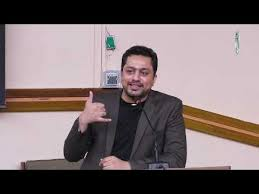

In [36]:
save_image_from_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIQEhUSEhIVFRUQFhAVFhcWFRUVFxYQFRUXFhYWFxYYHSggGBolHhcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0dHx0tLSstLSstLS0rKy0rLS0tLSstLS0rLS0tLS0tLS0tKy0tLS0tLS03Li03OCsrLSsrK//AABEIAMIBAwMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAAAQIDBAUHBgj/xABJEAABAwEDBgoECgkFAQEAAAABAAIDEQQhMQUGEkFRkRMiUmFxgZKhsdEyU3LSBxYkM0JDVLLB8BQVFzRzgpPC4SNEYqLxo2P/xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/xAAhEQEBAAICAQUBAQAAAAAAAAAAAQIRAxIxEyFBUWEEIv/aAAwDAQACEQMRAD8A4aiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICldIzCYP0k3D5t/i1dQhibyRuCNTHb5nRfUccTeSNwV9sLeSNwRelfKqL6u4FvJbuCkQt5LdwQ6PlBF9YcA3kt3BOAbyW7gh1fJ6L6w4FvJbuCngW8lu4IdXyci+seBbyW7gqXxNp6LcRqG0IdHygi+rZIm3cVuI1DYqImtJcC1tzjqGGr8dyHR8qovq/gW8lu4IYW8lu4IdK+UEX1dwLeS3cE4FvJbuCHR8oovq3gW8lu4JwLeS3cEOj5SRfV3BN5LdwTgm8lu4IdHyii+rTC3kt3BRwLeS3cEOj5TRfVnAt5LdwTgW8lu4IdHymi+rOBbyW7gnAt5LdwQ6PlNF9WcC3kt3BQ6Ng+i2/mCHR8qIvqvgW8lu4KDC3kt3BDo+VUX1TwLeSNwRDo5BmD+9H+G77zV1GBcvzAHyo80b/vNXUYVb5aw8MuNZDQrEavhGlSrAVKkFBUiIiUREUQVEuHW3xCrVEmHWPFFimXV7X9rl57K2XGWeWhrpCuqoLSXNobxfpAn/1egmxb7Z+49c8zni+USmtSCCG6yHG8Dnqa02V2LWLz/wBfJnx8e8PL31htYlYHjBwBGq4gHC/btWSvOZmz6UAaQQYy4EEU+kSPzzL0SldeLK54TK/IVC1+VsvWay/PzNYTg3Fx59EX0Wphz+sDruGoedrh1qOm3pkWPYbdFO3Tie17drSDfz7FkICKVCCCoVShASilEFKKpEELXWo/KIRU31FKGhJNam7UGml62NFjW2McR/0g9u6oH9yMcnhkIpIUURtCKaKEHG8wB8qP8N33mLqkIXLvg9/ej/Cf95q6lCrfLOHhlMVwKhqutUaVBS1QpagrVKqUFBAVShSiewqJMOsKuipk/EIsW5sY/b/setXbclwyvcZC7jEggPc2uOppxp3Laz4x+2fuPURx8YkbfPzQYeS8lR2duiwUqak6ycLzruAHUvP5/Z2foTOCiNJ3gEGgOhGTTSvuqaGgXsSuN5wt/SMrysdQhr4mj2WxsqN+kifkeXlgtVpJkIfIXYuxJPPrKsyWGYCronAC4nRIXb7HYWUuAbW/ACqqnyYHDUVz711nBL8uF2a1yQuDmvc28XglpFMDcu1Zj51i3NMbq8LE0Em6j24Fwpga0r0rzuceSIeDfWNtQDq1rSfBc4syg1oOMU7XbCLneLQtY5bc8sOlm3ZioVSLQpREQEREBERAVl7eODStxHRe03jWKDfRXkRLNwCgqURVKKpEHG/g9/enfwn/AHmrqUK5b8H/AO9H+G/7zV1KFW+WcPDLarrVaYrwCjSVWFFFUECiUUojKEopRAoqJNXSFWqXjDpCNLc1xZ7Xi1w/HvVJtUbSQXC49PgreUsB0nwWgtmUxZw0mMEOB41G10tIjRvGy/oaRrWscZfLOWWnpTbIzSjxf0rmULWtntloIvdPIwOcK0YKGoGw1/6r0Nmy2JzRsejQNq7ig1qLqADUHHG6it2WBmlI15FHOce9Tkkkb4P9X3aqzZzPaRouZK2oBAaWuBOokraZXzi0CGCE6bgCG6VO9XI8nQNc1ofXSdW80FRsGtY+U8lttMr2uLQaUbXX0EYG9c3q61gyW7hOLJHo6WI0g6/ZULT/AAa2F36zkNDowxzX87nMa0dYLty3LsjCAuLjVx1VNB0BZ/we2V7XzyUGjOSa/Sqw6LR0en3KY33sc+XG2Tb21EVShdHBSUoqlCCFKUSiCKKFUoIQQimiUQQimiUQQimiIOOfB8PlR/hu+81dThZzLh1ktD4ySxxaaUqCQaEjYskZZtA+uk7bvNTky6045uO6MYrzWFcJblu0evk7bvNVDLc/r5O27zXL1fx09P8AXdwxTorhX65n9c/tu81DsrzH6156Xv8ANPW/D0/13bRKaC4QcqS+sdvcqTlGT1jt5T1vw9P9d50U0VwF9uk1vcesqgWp+oneU9X8PT/X0CRzq3I4XXjHaFwM2mQ0Gk6gwFTQLZW2wcHZoLQ17iZdIPacGuvoW81AtTO34PT/AF13KczQWVIoKl1+AupvvXkcs2YTFp0iODDhcGmpLq1qXDbSlFzqWcvFHXg6v/VjGxxcgbgumGdnw454y/Lpub+T2Mkq55po6J+bFQXMvFHnk7NatZXe2N72g8YgPadukDS/pqOpc4jgY01DACL601ra2eN7YRPiS8mn/wCYoKDm4pPWnJe0a4r1vs3bLLPIaSivB00SHjAip+jUH81VqC1uszyGxvOlTSJq4UqOMHVor/6zs9oo7hXxGlBoOxdz1BFFi5WytFEykby5x1k39Kz8PReSa23Ftme+pJreAOc7F7fN+xmGFocKON7gaXG+65cTlyrKS0hxbQgtINKFpB0hz1ovQ5O+Ee2sIEgjmaMSW6Dz/Mzig/yqY4/Lnycu3XUXksl/CBZJaCTShJ5Y0m19puA6QF6izWlkjdKN7Xt2tcHDeFtz2uFAEUoCgqVCCEREBERARQUQSiiqIOA5PiaSS+oaBU0rXEAYLbxRWTWXnt+a1QlaRdG1pOsONfBXY6bV5+fP33HXh9sdNy2OwjU/fJ7yuaNgP0Hb5PxctONHlK4A3ldy8tyrv2jZgWIfQdXoJ7tK9WqWXZ/8x+L1h0btO4qaD/l2Sp3z+jtGyjmsIF8JPPojzVX6TYvs/wD1b7y1gZzP7J8lPBHU2TsO8lN5neNmbXYvs1eljPNUm32Mf7VvZjWt4B/q5D/K7yU/orz9VJ2HeSv+/pe8bvJk1lmkbG2yMq7WWx0A1k3allZ35Oe5kMUMbiGlxo1twoBTC4YlY+aVhcJDIWuboinGBFSdlehe1MoAqRVevhtk3WMv9TTktoyVKwVfE9o20u3rE0F1a0zODbqX1xAuHRrXMrZHoSObUGjnXjA36l6Mbt5eTj6+7EcKAnmKyMhZxsbEIJ7gBxX0uofou8+ZWrRcxx5j4LQmIK5YyucyuN3G3yjZ4CeEjkjNKkgObU9VVS6KCJ1ZXh1Gg0YCeMQCG1GNxx5liZPyvPZg4QzyRiS5wYaaXSsRoDzQ1q41Os7ST03rMx0vqT6boScJx9HRbQBrdjdXX5q0H0uAxWWwXCmF1OhUTNAJOvDrWmd7WQ0krJs5fGdJjnMcMHNcWkdBCmNmiL8cVS9+rWbzzN1qj32ZWd80krLNPx+EqGPuDqgE8blVpSuPSugEL5/ssh4VrmkjRIoQaHqIwXsLDnPaosJnOGyTj9543evPy8047Nu3Hjco6gi8bZM+z9bB1xu/td5rdWTOiyS/Whh2SAsv9o8U9RTHmwy8VbhY26USMhwq0gg6wajeFJC6SopUkKUV2ilQqioTYiiKUTY8xZskRj6tvZCzosnRj6tnZC2fBBTwaahvbFZYo/Vs7IV9tkj5DeyFd0VIV1BbFmZyW7gqxA3kjcFcClE2tiIbB3KeCGwblWgQ2oMY2LByvlCOztbpelIQ1jdZcSL+YCt58wtl3c645l3Lf6TbxI01a17WR8zGnEDnNT1po37ugaVRpE1JrerT7SG68ML7qrT5Syg6KMm64EjoXO5c5Z5SeNo+ysad8uSY+XVcpSz8EXQtDydQe1p6q4rwGULLapJHSvgeLqmjSQABj3YrVxZWnH1z96uNyxO6oMr6UpStLjiLtS1I5Z545LFsk4h6h3rUkrMyi/igbT4LBBPWum3nUlbLI1nvLtgp1n/CwFvclspGOe/f/hQTBxNJvJvHsn/N3WFS6g4x/JU2vEOH0MfZOPmrcjtJ4AwF6Kuk7ecnoWO4kCpHpm/o1NFMVXb5NFtOUQOpW479teipI8Goq/k94bIxzxVtRpDaDiG9C9WbJA/0ZNE7H3X9Jp4rx5r+bz5Bb6CSrQa4gLwf2TWrp6v58vMZ0mRpBeAHDa0+dBuWHJC5hvBHT+CrjkLfRJb7JI7llx5UkwcQ4f8AIX06R5Lw7xen2rEstofGase5h2scW76Lc2TPG1R3Oc2QbHtoe02nfVYRtcLvTiLa/SYaivSKeCCxRP8Am5QeZ2P4HuXSZZTxTpK9TZM+oz87C9vOwh4r3Fbux5ess1AyZlTqcdA7nUr1Lms2SpW/RrztNe7HuWHJGRcR1EUO7Fdcf6c55c8uGfDs9FBC5LYsrzw3RyvaNlai7mNQtxY89rQz0wyQc40Hb23dy74/1YfPs53isdC0UXk2Z+x0vgfXmc099yLp6+H2nTJ6sBTRVIvQ4KaJRVKFFiFKIhRKIpCI8xn/AJZ/RrMWtP8AqWjSY3mZTju3ED+YLj0Fs4KQSUBLamhwvBGrpr1BbjPXLTrVaXuwbGTGwbGtJv6TivMTO2KsWttlXOV08bY6UIaA87XUvpzLzrH0J6lepQKwahwH+Uhct1tYG6Qqsizx4nnVuzGjVmWX0eklVGtyliBsBPf/AIWHgr2UJayOGyg3D/KsE05ykRUKnDEr0cdGt5mjwWhsLKvaOeu5be0uvDegnoGA/OxFinhbuc3npKxIyWXjXt1cyzHXLDdV1+oEjruQql79N7QTtK2TWnUd4Woaf9QU1C5bQSgXGpOwCqBKKXeC6hm3kSz2mxQOfG0nQoXC51WuIN46Fy/SBwrXYbvFdX+Dd9bCwcl8w3vLv7lmzbeN1WNa8yG/VSubzOo4LTWrNa0s+i142sNDuK6TRCFwy/nwvw6zOuO2myPbc5rmH/k0jvwWOWHYCF2aSFrrnAHpvWptmbFmkqeD0SdbTonuXG/y/VdJy/bmkNqewcV7m82I3FZrMsPIpI1kg3Hy7l6K2Zj64pT0OAI3rSWzNi1R4xh42sP4FccuDknxt1nLFoTWZ+LXRnaLx3V8FUMmtffHI1/Nge7yWqlicw0c1zabRRUh2u7wXKyzzG+2NbF2Sn8nvHmixW2yQXBz+px80WfY/wAuyqURfcfPRVFNEooIRToqkyNH0hvCgkq1apNFj3DFrXu6wCfwVq0ZSgZ6c0bfae0eJWJPl2yEOabTFxgQeOMCKIOCzPrft8Viucr9sjMbiwmugSK6iBcCOY4rCe5Vzqt192KiyxVNVtMlR8CySZwIfoaMIcCDwkh0XSDZoNDqHa5uyotWWLuQ0uNFyzIHAMrsqfxUWewvkroMLtEVNATQG4E7L16KyZkzyx8d7YwR7Rp3DvS2RrHG5eHPa1JOJcSVWxlLyvV5dzHnsw0ozwzRjQaLuzrHQvKuJrTWLiNYI1EKy7Zyxs8s7JLeM5x1D8+Cy2GpLtvhqWNZRRgHLJJ6MAFfdJRCLVsloqYh/p43aR0hsJFBvv3BWZ4HnVdtV+Bv+m9pxLoj4hIixYQC555NB+K2ULgBhRYsNhp17VlCz0Fw/PNsRUvJOzpN+6i6f8F5+RmuqWTwauVadLtx28xG1dW+DBvyMnlSyHcGj8FGsXrlClFGkKURRpCEKVCosz2djxRzQ7pAK0tszSssl4ZoHawkL0BChS4yrLY8Q/4PmEmkz+5F7dFj0sfpe1VqlzqL50/aNlT7W7+nF7ig/CJlQ/7t39OL3F124dnaM78tSQxgwu0TpX3A3U5+deJOWJbQA+SR1S1laEtGA1DaaleBtmd9tmFJJy7+WMeDVhxZctDRRshA6G+SzWrnNOivId6VXe0SfEqng28kblz/AOMFp9adzfJPjDafWnst8lNJ2dDawamjcFVpLnfxitXrT2WeSj4w2n1p7LfJOp2e7tlijlpptrTXeDvCsQZIhYQ4Rio2kkdNCV4v4w2r1p7LfJPjBafWnc3yTSbj0uUn8I/mbcPz+cFjxx0XmzlWbl9zfJP1tNy+5vkt7Tb3uRLY2IivpPc1pxuZdeNpr4BdKsTBQU0iNRfcekB146gvnqPLE7SHCQgtNQaNx3LZNz2ygMLS7sx+6sWbdsObrNO6PjxBNVrZ8hWeY1kiY47SBXfiuP8Ax6yj9pd2I/dUjPrKI/3J7EXuqdW7z434eqy9kkQyuYBdcR0LXgUFCAV5i2ZzWuZ2lJMXGlK6LBd1BWP11P6z/qw/gukrz2zb1tjsznuLGuDQGl3o1uBwxV205JZGKumIqKm4C5t41ryMWX7Q30XgVFPm48Oyq35y2p2MgPTHEfFq1MpGXrsnWKORpLZn3HDinxxHQsQS6ibxUdYJC823OS1BwcJKECgoyMXVrgG0V4Z223157EfuqXKLNNqRiNfjsK7LmNZxDYYATQuaZDW75xxfgeYhcF+N1t9eeyz3VBzstvrz2We6s7alj6WNoZy27wqHWyMYyM7TfNfNnxstnrz2We6hzstvrz2We6p7r2xfSByjD61naCpOVYB9Y3v8l84fGu2evPZZ7qHOu2evPZZ5J7r3xfRjcswFzWCS95DRxXXuPUtgvmSPOy2Nc1wnNWEOB0IzRwwIq1Z/7Rsqfa3f04vcVS5z4fRZUL51/aNlT7W7+nF7iftGyp9rd/Ti9xDu+ikXzr+0XKn2t39OL3EQ7vKoiI5iIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIP/Z","q2.jpg")

In [17]:
# Example usage
image_path = "./images/q2.jpg"
q2 = create_image_embedding(image_path)

# 'embedding' now contains a dense vector representation of the image
print("Image Embedding Shape:", q2.shape) # embedding length
print("Image Embedding:", q2)

Image Embedding Shape: (512,)
Image Embedding: [ 0.00058278 -0.01463297 -0.10330155  0.03984535  0.08525636  0.08029363
 -0.01011138  0.04867227 -0.00259888 -0.0077198  -0.0331905   0.06225294
  0.01708761 -0.00982595 -0.01638006  0.00054205  0.04426373  0.00519726
  0.04448376 -0.08979201 -0.06033407 -0.00162232  0.09186839  0.03262272
  0.06873461  0.02532319  0.03512866 -0.05809444  0.00151727  0.05172818
 -0.04107905 -0.03755797 -0.04134395 -0.00761167 -0.00674731  0.04443471
  0.00570058 -0.02845279 -0.12002273  0.05528227  0.00132485  0.00437373
 -0.02495593  0.01842853 -0.00357915  0.01889837  0.02980521  0.10357354
 -0.11238679 -0.02633037  0.02794239 -0.0152881   0.04015452 -0.0039458
 -0.09202526  0.0715652  -0.03382103  0.07384298  0.01921727 -0.04263638
  0.02758526  0.03841295 -0.04435986 -0.05347932 -0.04511738  0.03700717
 -0.00194125 -0.00450149  0.03157888  0.02796174  0.02416223  0.01202647
 -0.00905218  0.00880154  0.0189873  -0.01363976 -0.0499587  -0.01557556
  0.0

In [18]:
image_path = "./images/z2.jpg"
cat2 = create_image_embedding(image_path)

# 'embedding' now contains a dense vector representation of the image
print("Image Embedding Shape:", cat2.shape)
print("Image Embedding:", cat2)


Image Embedding Shape: (512,)
Image Embedding: [ 2.89454460e-02  3.42947012e-03 -2.74505597e-02  7.37803280e-02
 -4.99105752e-02  5.99015020e-02 -5.80016971e-02  9.61501990e-03
 -3.76116224e-02  6.68167919e-02  3.29056494e-02  7.69131184e-02
 -2.71448866e-02 -7.38206208e-02 -6.41608890e-03 -1.75792407e-02
 -2.86509236e-03  2.43324263e-04  2.99515016e-02 -6.26092330e-02
 -9.17221606e-02  5.20209968e-02  7.77745945e-03 -9.54604298e-02
 -3.56662348e-02 -3.14501068e-03 -2.61445008e-02 -2.82874722e-02
 -3.14870514e-02 -4.62670997e-03  9.74005926e-03  5.31971268e-02
  6.94989115e-02 -9.61332640e-04 -1.50304316e-02 -2.41529979e-02
  3.29998098e-02 -2.09973361e-02 -1.83389876e-02  2.21958589e-02
  1.38924932e-02 -3.18161473e-02  2.27779280e-02 -3.22516039e-02
 -4.14354913e-02 -1.07177757e-02 -4.29533934e-03 -2.32607424e-02
  8.63501430e-03 -3.14582288e-02  7.96774961e-03  9.41322092e-03
  4.40274179e-02 -1.76512506e-02 -2.90919878e-02  3.98665154e-03
  4.76254076e-02  6.09371029e-02 -5.0816565

In [19]:
q1 = create_image_embedding("./images/q1.jpg")
q2 = create_image_embedding("./images/q2.jpg")
s1 = create_image_embedding("./images/s1.jpg")
s2 = create_image_embedding("./images/s2.jpg")
z1 = create_image_embedding("./images/z1.jpg")
z2 = create_image_embedding("./images/z2.jpg")

In [20]:
!pip install -U milvus-lite

!pip install -U pymilvus


In [21]:
from pymilvus import MilvusClient
client = MilvusClient("./milvus_demo.db")


In [22]:
from pymilvus import MilvusClient
import numpy as np

client = MilvusClient("./milvus_demo.db")
client.create_collection(
    collection_name="images",
    dimension=512  # The vectors we will use in this demo has 384 dimensions
)

In [23]:
data = [
    {"id": 1, "person_name": "Qasim", "vector": q1},
    {"id": 2, "person_name": "Qasim", "vector": q2},
    {"id": 3, "person_name": "Raheela", "vector": s1},
    {"id": 4, "person_name": "Raheela", "vector": s2},
    {"id": 5, "person_name": "Zia Khan", "vector": z1},
    {"id": 6, "person_name": "Zia Khan", "vector": z2}
]


In [30]:
res = client.insert(
    collection_name="images",
    data=data
)

In [31]:
res = client.search(
    collection_name="images",
    data=[q1],
    limit=1,
    output_fields=["id", "person_name"],
)
print(res)


data: ["[{'id': 1, 'distance': 0.9999999403953552, 'entity': {'person_name': 'Qasim', 'id': 1}}]"]


In [32]:
res = client.search(
    collection_name="images",
    data=[s1],
    limit=1,
    output_fields=["id", "person_name"],
)
print(res)


data: ["[{'id': 3, 'distance': 1.0000001192092896, 'entity': {'person_name': 'Raheela', 'id': 3}}]"]


In [35]:
# create embedding
s3 = create_image_embedding('./images/s3.jpg')
s3


array([ 2.15259064e-02, -2.06278823e-02, -8.21088906e-03,  3.95362377e-02,
       -6.84244037e-02, -6.23256201e-03,  1.41432611e-02, -2.68529775e-03,
       -1.47243459e-02, -5.12116067e-02,  3.55445780e-02, -3.58490506e-03,
        2.32236236e-02,  2.28648707e-02, -1.19223250e-02,  8.41544718e-02,
       -3.13474722e-02, -7.66968727e-03, -5.98902395e-03, -8.17210693e-03,
       -5.99547755e-03, -2.66386382e-02,  1.83248296e-02, -4.89270687e-02,
        1.59225464e-02,  2.02786885e-02, -1.24048591e-02, -6.83889389e-02,
        1.55869350e-02, -9.69097912e-02, -4.14089598e-02,  4.65782136e-02,
       -4.34597395e-02,  5.54773957e-02, -7.97020644e-02,  7.00245127e-02,
        9.50614214e-02,  2.43805535e-02, -2.54709180e-02, -5.30068837e-02,
        7.12321466e-03, -4.01432477e-02,  5.68777695e-02, -7.34510971e-03,
       -3.20849381e-02, -5.90283573e-02, -5.14790765e-04,  3.36408503e-02,
       -5.08080050e-02,  3.81267630e-02,  3.09965275e-02,  3.08582261e-02,
        2.18173526e-02,  

In [37]:
res = client.search(
    collection_name="images",
    data=[s3],
    limit=2,
    output_fields=["id", "person_name"],
)
print(res)

data: ["[{'id': 3, 'distance': 0.40487685799598694, 'entity': {'person_name': 'Raheela', 'id': 3}}]"]
